In [1]:
# === 0) ENVIRONMENT, PATHS, HELPERS ===
import os, sys, re, json, math, random, platform
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, roc_auc_score, average_precision_score,
                             precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,
                             brier_score_loss, roc_curve, precision_recall_curve)

from joblib import dump

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Python:", sys.version.split()[0], "| sklearn/pandas/numpy:")
import sklearn, pandas, numpy
print(sklearn.__version__, pandas.__version__, numpy.__version__)


Python: 3.11.13 | sklearn/pandas/numpy:
1.2.2 2.2.3 1.26.4


In [2]:
# Paths
INPUT_ROOT = Path("/kaggle/input")
WORK_ROOT  = Path("/kaggle/working")
ART        = WORK_ROOT / "artifacts"
ART.mkdir(exist_ok=True, parents=True)

# Try to find a spam.csv inside Kaggle /input
def find_spam_csv():
    candidates = []
    for root, dirs, files in os.walk(INPUT_ROOT):
        for f in files:
            if f.lower() == "spam.csv":
                candidates.append(Path(root) / f)
    return candidates[0] if candidates else None

SPAM_PATH = find_spam_csv()
print("Detected spam dataset path:", SPAM_PATH)
if SPAM_PATH is None:
    print("⚠️ Attach the dataset in right sidebar: Add Data → 'SMS Spam Collection Dataset'.")


Detected spam dataset path: /kaggle/input/d/uciml/sms-spam-collection-dataset/spam.csv


In [3]:
# === 1) SELECTION ===
# Most Kaggle SMS datasets have columns: v1 (label: ham/spam), v2 (text)
# We keep only the necessary columns to avoid extra noise.

assert SPAM_PATH is not None, "Dataset not found. Please Add Data (SMS Spam Collection) and re-run."

df_raw = pd.read_csv(SPAM_PATH, encoding="latin-1")
print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (5572, 5)


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Keep label + text, rename to ['label','text'] and convert label to 0/1
df = df_raw.rename(columns={"v1":"label", "v2":"text"})
df = df[["label", "text"]].copy()

# Map labels: ham->0, spam->1
df["label"] = (df["label"].str.lower() == "spam").astype(int)
df = df.dropna(subset=["text"]).reset_index(drop=True)

print("After select/clean:", df.shape)
print(df["label"].value_counts().rename({0:"ham",1:"spam"}))
df.head(3)


After select/clean: (5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
# === 2) PREPROCESSING ===
import re

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"http\\S+|www\\S+", " URL ", s)  # URLs -> token
    s = re.sub(r"\\d+", " NUM ", s)              # numbers -> token
    s = re.sub(r"[^a-z\\s]", " ", s)             # keep letters/spaces
    s = re.sub(r"\\s+", " ", s).strip()
    return s

df["clean"] = df["text"].astype(str).apply(clean_text)
df.sample(5, random_state=SEED)


,label,text,clean
3245,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",funny fact nobody teaches volcanoes erupt t...
944,0,I sent my scores to sophas and i had to do sec...,i sent my scores to sophas and i had to do sec...
1044,1,We know someone who you know that fancies you....,we know someone who you know that fancies you ...
2484,0,Only if you promise your getting out as SOON a...,only if you promise your getting out as soon a...
812,1,Congratulations ur awarded either å£500 of CD ...,congratulations ur awarded either of cd ...


Ham/Spam counts:
 label
0    4825
1     747
Name: count, dtype: int64

Length (tokens) summary:
        count       mean        std  min   25%   50%   75%    max
label                                                            
0      4825.0  14.463420  11.591440  0.0   7.0  11.0  19.0  190.0
1       747.0  22.961178   5.801899  1.0  21.0  24.0  27.0   36.0


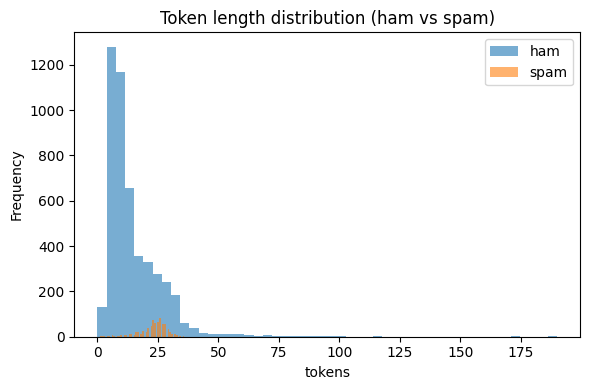

In [6]:
# Class balance + basic length stats
df["len"] = df["clean"].str.split().apply(len)
print("Ham/Spam counts:\n", df["label"].value_counts())
print("\nLength (tokens) summary:")
print(df.groupby("label")["len"].describe())

# Plot length distributions (optional)
plt.figure(figsize=(6,4))
df[df.label==0]["len"].plot(kind="hist", alpha=0.6, bins=50)
df[df.label==1]["len"].plot(kind="hist", alpha=0.6, bins=50)
plt.title("Token length distribution (ham vs spam)")
plt.xlabel("tokens")
plt.legend(["ham","spam"])
plt.tight_layout(); plt.show()


In [7]:
# === 3) TRANSFORMATION ===
# Train/validation split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"],
    test_size=0.2, stratify=df["label"], random_state=SEED
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

# TF-IDF (1-2 grams), capped features to run fast on Kaggle
tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2), max_features=30000)


Train/Test shapes: (4457,) (1115,)


In [8]:
# === 4) DATA MINING ===
# Lightweight baseline: Logistic Regression with class_weight='balanced'
# Good discrimination, fast to train, easy to calibrate.
lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED)

clf = Pipeline([
    ("tfidf", tfidf),
    ("lr", lr),
])

# Cross-validated AUC on train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_auc = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"[CV-5] ROC AUC: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}")

# Fit on full train
clf.fit(X_train, y_train)

# Predict on holdout
proba = clf.predict_proba(X_test)[:,1]
pred05 = (proba >= 0.5).astype(int)

hold_auc = roc_auc_score(y_test, proba)
hold_ap  = average_precision_score(y_test, proba)  # PR AUC
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred05, average="binary", zero_division=0)
brier = brier_score_loss(y_test, proba)

print(f"[Holdout] ROC AUC: {hold_auc:.3f} | PR AUC: {hold_ap:.3f} | F1@0.50: {f1:.3f} | Brier: {brier:.3f}")
print("\nClassification report @0.50:\n", classification_report(y_test, pred05, digits=3))


[CV-5] ROC AUC: 0.993 ± 0.003
[Holdout] ROC AUC: 0.990 | PR AUC: 0.973 | F1@0.50: 0.939 | Brier: 0.028

Classification report @0.50:
               precision    recall  f1-score   support

           0      0.989     0.993     0.991       966
           1      0.952     0.926     0.939       149

    accuracy                          0.984      1115
   macro avg      0.970     0.959     0.965      1115
weighted avg      0.984     0.984     0.984      1115



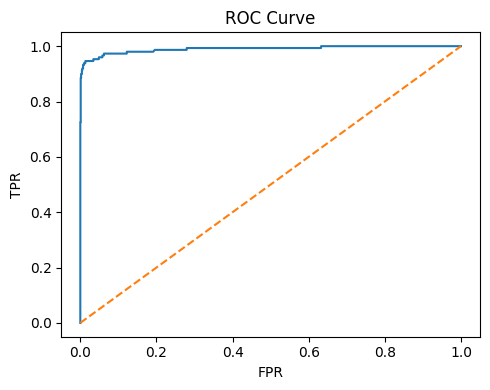

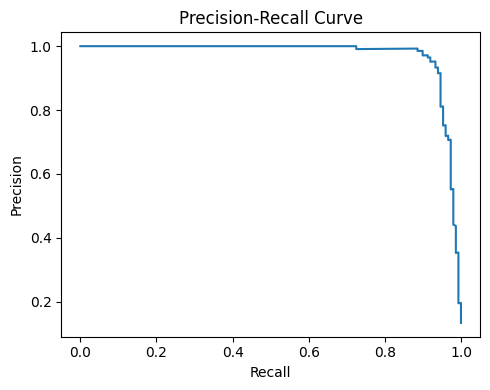

Best F1 threshold on holdout: 0.500 | F1: 0.939


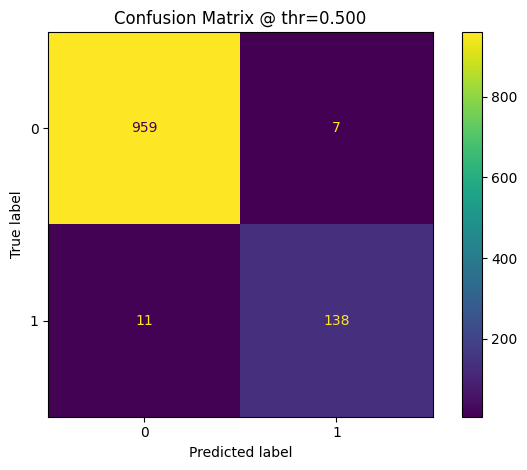


Top 5 False Positives:
                                                    text     proba
187                               waiting for your call  0.841771
532   call to the number which is available in appoi...  0.647789
310                              ok    ur typical reply  0.631375
1111  we have sent jd for customer service cum accou...  0.616450
174              call me da  i am waiting for your call  0.556151

Top 5 False Negatives:
                                                    text     proba
852   do you realize that in about    years  we ll h...  0.088214
1069  hi ya babe x u  goten bout me   scammers getti...  0.143234
196                                        ringtoneking  0.168375
478   for sale   arsenal dartboard  good condition b...  0.204884
841   romcapspam everyone around should be respondin...  0.267243


In [9]:
# === 5) INTERPRETATION / EVALUATION ===

# ROC curve
fpr, tpr, thr = roc_curve(y_test, proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.tight_layout(); plt.show()

# PR curve
pp, rr, thr_pr = precision_recall_curve(y_test, proba)
plt.figure(figsize=(5,4))
plt.plot(rr, pp)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

# Threshold sweep to optimize F1
thr_grid = np.linspace(0.1, 0.9, 17)
best_f1, best_thr = -1, 0.5
for t in thr_grid:
    pr = (proba >= t).astype(int)
    _, _, f1_t, _ = precision_recall_fscore_support(y_test, pr, average="binary", zero_division=0)
    if f1_t > best_f1:
        best_f1, best_thr = f1_t, t

print(f"Best F1 threshold on holdout: {best_thr:.3f} | F1: {best_f1:.3f}")

# Confusion matrix @ best threshold
pred_best = (proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, pred_best)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title(f"Confusion Matrix @ thr={best_thr:.3f}")
plt.tight_layout(); plt.show()

# Quick error analysis: top false positives and false negatives
test_df = pd.DataFrame({"text": X_test, "y": y_test, "proba": proba, "pred": pred_best}).reset_index(drop=True)
fp = test_df[(test_df.y==0) & (test_df.pred==1)].sort_values("proba", ascending=False).head(5)
fn = test_df[(test_df.y==1) & (test_df.pred==0)].sort_values("proba", ascending=True).head(5)

print("\nTop 5 False Positives:\n", fp[["text","proba"]])
print("\nTop 5 False Negatives:\n", fn[["text","proba"]])


In [10]:
# === 6) ARTIFACTS / SUMMARY ===
model_path = ART / f"sms_tfidf_logreg_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
dump(clf, model_path)
print("Saved model to:", model_path)

summary = {
    "time": datetime.now().isoformat(),
    "cv_auc_mean": float(cv_auc.mean()),
    "cv_auc_std": float(cv_auc.std()),
    "holdout_auc": float(hold_auc),
    "holdout_pr_auc": float(hold_ap),
    "brier": float(brier),
    "best_f1_thr": float(best_thr),
    "best_f1": float(best_f1),
    "train_size": int(X_train.shape[0]),
    "test_size": int(X_test.shape[0])
}
with open(ART / "run_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\n=== Run Summary ===")
for k,v in summary.items():
    print(f"{k}: {v}")


Saved model to: /kaggle/working/artifacts/sms_tfidf_logreg_20251103_043659.joblib

=== Run Summary ===
time: 2025-11-03T04:36:59.596527
cv_auc_mean: 0.9926174212653954
cv_auc_std: 0.003107806252581335
holdout_auc: 0.989856461989523
holdout_pr_auc: 0.9729158903486019
brier: 0.028181281198984852
best_f1_thr: 0.5
best_f1: 0.9387755102040818
train_size: 4457
test_size: 1115


In [11]:
# === 7) OPTIONAL: TOP FEATURES ===
# Pull out feature names & coefficients from pipeline for quick interpretability
vec = clf.named_steps["tfidf"]
lr  = clf.named_steps["lr"]
feat_names = np.array(vec.get_feature_names_out())
coefs = lr.coef_[0]

top_spam_idx = np.argsort(coefs)[-20:][::-1]
top_ham_idx  = np.argsort(coefs)[:20]

print("\nTop spam-weighted ngrams:")
print(pd.DataFrame({"ngram": feat_names[top_spam_idx], "coef": coefs[top_spam_idx]}).head(20))

print("\nTop ham-weighted ngrams:")
print(pd.DataFrame({"ngram": feat_names[top_ham_idx], "coef": coefs[top_ham_idx]}).head(20))



Top spam-weighted ngrams:
      ngram      coef
0       txt  5.300011
1      call  5.243814
2      free  4.113648
3      text  3.825849
4        to  3.777494
5     reply  3.389202
6        uk  3.307094
7    mobile  3.150774
8      stop  3.130181
9      your  3.051606
10      www  3.039216
11    claim  2.927867
12     from  2.909834
13      com  2.575049
14  service  2.559458
15      now  2.541870
16      win  2.447116
17     chat  2.385743
18      won  2.308957
19       or  2.287894

Top ham-weighted ngrams:
    ngram      coef
0      my -2.553046
1      me -2.187590
2      ok -1.902021
3    that -1.851704
4      ll -1.654713
5     but -1.654342
6      gt -1.563584
7      it -1.559391
8      lt -1.534250
9     can -1.419006
10   home -1.393634
11     so -1.388005
12   come -1.358027
13     at -1.345586
14  lt gt -1.345499
15   when -1.314902
16  later -1.306014
17   what -1.284180
18    how -1.256327
19   then -1.254646
